# Word Embedding + CNN

1. x_train: \[text1, text2, ...\]
   y_train: \[[label11, label12, ...], [label21, ...], ...\]

2. Generate vocabulary set and get token_to_id map. This map will map a word to an index in vocabulary space. Transform text to \[index1, index2, ..., \]. 

   Padded sequences to fixed length (750, )
    
3. Word Vector - Google News 300

4. Do classification by CNN

![](https://i.loli.net/2018/12/22/5c1df43d21bd7.jpg)

5. Using MultilabelBinarizer mapping \[label1, label2, ...\] to [1,1,0,0,...,] by one-hot.

The accuracy is 0.82.

In [21]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
%autoreload

In [23]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [24]:
result_path = 'running_result/wordemb_cnn'

## Data preprocess part

We construct documents as $[d_1, d_2, ..., d_m]$ and labels as $[y_1, ..., y_m]$.

In [25]:
from src.data_preprocess.preprocess import DataSet
dataset = DataSet()
raw_x_train, raw_y_train, raw_x_test, raw_y_test = dataset.get_train_and_test_documents()

========== Extract data from pickle files ==========


Tokenize document text into a list of tokens \['u.s.', 'econom', 'data', 'debt', 'chicago', 'interest',...\] using NLTK library and remove stop-words from tokens, such as \['a', 'the', ...\]. 

In [26]:
from nltk.tokenize import word_tokenize
from src.data_preprocess.preprocess import stop_words_
import re

def convert_text_to_word_list(text: str) -> []:
    word_tokens = word_tokenize(text)
    tokens = []
    for word in word_tokens:
        # remove punctturation and stop word
        word = word.replace('*', '')
        if re.compile(r'[a-z]').search(word) is None or word in stop_words_ or len(word) <= 3:
            continue
        tokens.append(word)
    return tokens

In [27]:
from nltk.tokenize import word_tokenize
x_train = []
y_train = raw_y_train.copy()
x_test = []
y_test = []
bag_of_classes = set()

for i, x in enumerate(raw_x_train):
    bag_of_classes = bag_of_classes.union(raw_y_train[i])
    tokens = convert_text_to_word_list(x)
    x_train.append(' '.join(tokens))
        
for i, x in enumerate(raw_x_test):
    labels = [class_ for class_ in raw_y_test[i] if class_ in bag_of_classes]
    if len(labels) == 0:
        continue
    tokens = convert_text_to_word_list(x)
    x_test.append(' '.join(tokens))
    y_test.append(labels)

len(x_train), len(y_train), len(x_test), len(y_test)

(7310, 7310, 3353, 3353)

In [28]:
x_train[300]

'summit petroleum corp sells shares abilene texas march summit petroleum corp sold shares common stock halbert associates company shares previously held consolidated energy corp harken hogi addition david halbert president chief executive officer halbert abilene investment firm named chairman chief executive summit company halbert charles bruce james burke named directors expanding board summit added company burke president chief executive allied comprehensive health abilene bruce partner washington firm butler binion summit intends actively seek acquisitions increase asset base reuter'

# Convert text to vector

In [29]:
from keras.preprocessing.text import Tokenizer

MAX_NUM_WORDS = 20000

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='UNK')
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

len(tokenizer.word_index)

23292

In [30]:
word_index = tokenizer.word_index
len(word_index)

23292

In [31]:
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 730

data_train_X = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
data_test_X = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
data_train_X.shape, data_test_X.shape

((7310, 730), (3353, 730))

In [32]:
data_train_X[300]

array([ 3332,   230,    12,   704,    17,  9420,   296,     3,  3332,
         230,    12,   203,    17,    69,    18,  8076,  1136,    10,
          17,   211,   234,   774,   200,    12, 14861, 14862,   576,
        1097,  8076,   106,   396,   327,   711,  8076,  9420,    85,
         195,  1029,   129,   396,   327,  3332,    10,  8076,  1972,
        4108,   759,  9421,  1029,   488,  2016,    53,  3332,    67,
          10,  9421,   106,   396,   327,   967,  2830,   776,  9420,
        4108,  1470,    57,   195,  4109, 14863,  3332,  1085,  2209,
         548,   658,    62,  1099,   312,     4,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [33]:
from sklearn.preprocessing import MultiLabelBinarizer

lb = MultiLabelBinarizer()
lb.fit(y_train)

MultiLabelBinarizer(classes=None, sparse_output=False)

In [34]:
y_train_vector = lb.transform(y_train)
y_test_vector = lb.transform(y_test)
y_train_vector[::300], y_test_vector.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]]), (3353, 88))

In [35]:
multi_vectors = [vector for vector in y_test_vector if sum(vector) > 1]
len(multi_vectors)

467

In [36]:
from sklearn.model_selection import train_test_split

train_X, val_x, train_y, val_y = train_test_split(data_train_X, y_train_vector, test_size=1000, random_state=65)

data_test_y = y_test_vector

# Build word vector matrix

Using word2vec algorithm to train the word vector on document. We can get a dict {str: (300,)} as result.

'spokesman': \[-0.0147094, -0.05737305, 0.14257812, -0.29882812, 0.15527344, -0.28710938, 0.05151367, -0.03125, …\]

Convert each document "economy each year..." -> (n, 300) word vector. Let n = 1500. Padding documents with fewer words than 1500. Now each document is (1500, 300) matrix and all document format as a (m, 1500, 300) tensor.


In [37]:
# Use Google News 300 dimension word vector
from gensim.models import KeyedVectors
filename = '~/gensim-data/GoogleNews-300/GoogleNews-vectors-negative300.bin'
embedding_wv_model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [38]:
import numpy as np
EMBEDDING_DIM = embedding_wv_model.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    if word in embedding_wv_model.vocab:
        embedding_matrix[i] = embedding_wv_model.get_vector(word)

In [40]:
embedding_matrix[200]

array([-0.10351562,  0.16113281,  0.1171875 , -0.25390625,  0.00891113,
        0.00823975,  0.10302734, -0.40039062,  0.09423828,  0.03063965,
        0.0390625 ,  0.07958984, -0.03955078, -0.06494141, -0.13085938,
        0.00976562, -0.08544922,  0.14160156,  0.17285156,  0.07910156,
        0.03344727, -0.08935547, -0.01263428,  0.3046875 , -0.12060547,
        0.2890625 , -0.12890625, -0.00561523,  0.01452637, -0.11181641,
       -0.08398438, -0.02954102, -0.09472656,  0.10107422,  0.05859375,
       -0.06225586,  0.05810547,  0.05224609,  0.07177734,  0.375     ,
       -0.06030273, -0.14648438,  0.21484375,  0.05810547, -0.12890625,
       -0.00793457, -0.14355469, -0.09521484, -0.1640625 ,  0.17675781,
        0.09814453,  0.15625   , -0.01953125,  0.16601562,  0.06835938,
       -0.08447266, -0.08056641, -0.26171875,  0.10107422, -0.13085938,
       -0.04174805, -0.15722656, -0.19433594,  0.125     , -0.0043335 ,
       -0.07373047, -0.13769531,  0.16503906, -0.19921875,  0.05

# Classification.

We use Keras to train neural network part. The shape of input layer is (1500, 300). The input layer connects to three convolution layer of which the region size is 3, 4, 5 respectively. Each layer contains 256 filters, the stride is 1 and the activation function is 'RELU'. The result of CNN will feed into max pooling layer. Then, concat and flatten all filters. Use fully-connected neural networks with softmax to classify labels. Combining with dropout (0.2) to avoid overfitting.

In [41]:
import keras
import keras.layers as L
from keras.models import Model

In [42]:
input_layer = L.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
l_emd = L.Embedding(input_dim=len(word_index)+1, 
                    output_dim=EMBEDDING_DIM, 
                    weights=[embedding_matrix], 
                    input_length=MAX_SEQUENCE_LENGTH, 
                    trainable=False)(input_layer)
l_conv1 = L.Conv1D(256, 3, padding='same', strides=1, activation='relu')(l_emd)
l_maxpool1 = L.MaxPool1D(4)(l_conv1)

l_conv2 = L.Conv1D(256, 4, padding='same', strides=1, activation='relu')(l_emd)
l_maxpool2 = L.MaxPool1D(4)(l_conv2)

l_conv3 = L.Conv1D(256, 5, padding='same', strides=1, activation='relu')(l_emd)
l_maxpool3 = L.MaxPool1D(4)(l_conv2)

l_combined = L.Concatenate()([l_maxpool1, l_maxpool2, l_maxpool3])
flat = L.Flatten()(l_combined)
drop = L.Dropout(0.2)(flat)

output = L.Dense(y_train_vector.shape[1], activation='softmax')(drop)

model = Model(input_layer, output)

In [43]:
l_conv3.shape

TensorShape([Dimension(None), Dimension(730), Dimension(256)])

In [44]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
# early stoppping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=2)

batch_size = 256
epochs = 15

history = model.fit(train_X, 
          train_y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_x, val_y),
          callbacks=[early_stopping])

Train on 6310 samples, validate on 1000 samples
Epoch 1/15
6310/6310 [==============================] - 141s 22ms/step - loss: 3.0265 - acc: 0.4609 - val_loss: 2.1184 - val_acc: 0.6200
Epoch 2/15
6310/6310 [==============================] - 133s 21ms/step - loss: 1.6038 - acc: 0.7228 - val_loss: 1.5463 - val_acc: 0.7560
Epoch 3/15
6310/6310 [==============================] - 133s 21ms/step - loss: 1.0307 - acc: 0.8349 - val_loss: 1.3315 - val_acc: 0.8280
Epoch 4/15
6310/6310 [==============================] - 133s 21ms/step - loss: 0.8303 - acc: 0.8868 - val_loss: 1.3390 - val_acc: 0.8430
Epoch 5/15
6310/6310 [==============================] - 132s 21ms/step - loss: 0.7646 - acc: 0.9144 - val_loss: 1.2889 - val_acc: 0.8500
Epoch 6/15
6310/6310 [==============================] - 132s 21ms/step - loss: 0.6952 - acc: 0.9195 - val_loss: 1.1756 - val_acc: 0.8560
Epoch 7/15
6310/6310 [==============================] - 134s 21ms/step - loss: 0.6632 - acc: 0.9235 - val_loss: 1.2036 - val_acc: 

KeyboardInterrupt: 

# Plot loss for training dataset and validation dataset

In [46]:
import matplotlib.pyplot as plt
import datetime

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('{}/Google-News-300-loss-multilabel-{}.svg'.format(result_path, datetime.datetime.today()))
plt.show()


NameError: name 'history' is not defined

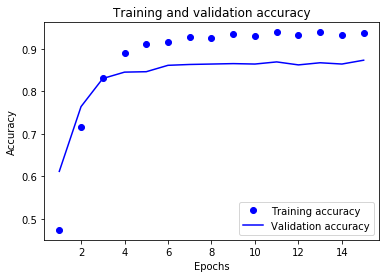

In [76]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('{}/Google-News-300-acc-multilabel-{}.svg'.format(result_path, datetime.datetime.today()))
plt.show()


# Test Metric

In [77]:
score, acc = model.evaluate(data_test_X, data_test_y, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

3355/3355 [==============================] - 27s 8ms/step
Test score: 1.4517079295060318
Test accuracy: 0.8229508198320243


In [192]:
y_pred = model.predict(x=data_test_X)

In [193]:
y_pred_label = np.zeros_like(y_pred)
y_pred_label[np.arange(len(y_pred)), y_pred.argmax(1)] = 1

In [194]:
y_pred_label

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [195]:
y_pred_label.shape

(3347, 73)

In [196]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred_label, data_test_y)

0.6235434717657604